In [1]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import csv
import pickle
import random
import cv2

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from tensorflow.math import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

from scipy import ndimage

In [6]:
# DCM Series Number extraction for ADC_MAPS images from csv file

series = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'ADC':
            series.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])


series = sorted(series, key=lambda x: (x[0],x[1]))

# DCM Series Number extraction for CT_SCANS images from csv file

series2 = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Images-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        #print(', '.join(row))
        if row[-2][-3:] == 'tra':#cor
            series2.append([row[0], row[2], row[3], row[-9], row[-2],row[-1]])

series2 = sorted(series2, key=lambda x: (x[0],x[1]))

print(np.asarray(series).shape, np.asarray(series2).shape)
print(series, series2)

(341, 6) (413, 6)
[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '36 72 9', 'ep2d_diff_tra_DYNDIST_ADC', '7'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '34 63 10', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '8'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '33 71 12', 'ep2d_diff_tra_DYNDIST_ADC', '7'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', '45 70 9', 'ep2d_diff_tra_DYNDIST_ADC', '7'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', '54 68 11', 'ep2d_diff_tra_DYNDIST_ADC', '6'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', '33 57 16', 'ep2d_diff_tra_DYNDIST_ADC', '6'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', '50 58 8', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '7'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', '46 75 9', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '7'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', '42 63 9', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '7'],

In [7]:
# True or false extraction for ADC images from csv file

clinsig = []

with open('/Users/langletmaxime/Desktop/ProstateX/ProstateX-TrainingLesionInformationv2/ProstateX-Findings-Train.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in spamreader:
        clinsig.append([row[0],row[1], row[2], row[-1]])
    clinsig.remove(clinsig[0])

clinsig2 = clinsig
#for n in range(len(clinsig)):
    #print(n, clinsig[n])
    
    
#duplicates removing
    
cp = []
cl = clinsig.copy()
j=0
n=0
seen = []

while j != len(series):
    if clinsig[n][0] == series[j][0] and clinsig[n][1] == series[j][1] and clinsig[n][2] == series[j][2]:
        if clinsig[n] not in seen:
            cp.append([clinsig[n], series[j]])
            seen.append(clinsig[n])
        j+=1
    n+=1
    if n == len(clinsig):
        n=0
        
    
cp2 = []
cl = clinsig2.copy()
j=0
n=0
seen = []

while j != len(series2):
    if clinsig2[n][0] == series2[j][0] and clinsig2[n][1] == series2[j][1] and clinsig2[n][2] == series2[j][2]:
        if clinsig[n] not in seen:
            cp2.append([clinsig2[n], series2[j]])
            seen.append(clinsig2[n])
        j+=1
    n+=1
    if n == len(clinsig2):
        n=0

print(clinsig, clinsig2)
print(len(clinsig), len(clinsig2))

cp.remove(cp[307])

[['ProstateX-0000', '1', '25.7457 31.8707 -38.511', 'TRUE'], ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', 'FALSE'], ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', 'TRUE'], ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', 'FALSE'], ['ProstateX-0003', '1', '22.1495 31.2717 -2.45933', 'FALSE'], ['ProstateX-0003', '2', '-21.2871 19.3995 19.7429', 'FALSE'], ['ProstateX-0004', '1', '-7.69665 3.64226 23.1659', 'FALSE'], ['ProstateX-0005', '0', '-14.5174331665039 49.4428329467773 20.7815246582031', 'TRUE'], ['ProstateX-0005', '1', '-38.6276 42.2781 21.4084', 'TRUE'], ['ProstateX-0005', '1', '-22.0892639160156 25.4668045043945 22.8791542053223', 'FALSE'], ['ProstateX-0006', '1', '8.20024 28.2665 -10.4784', 'FALSE'], ['ProstateX-0006', '2', '-9.85971 37.2739 0.561445', 'FALSE'], ['ProstateX-0007', '1', '-5.4258 20.1075 -57.34', 'FALSE'], ['ProstateX-0008', '1', '25.2302 38.6613 -26.864', 'FALSE'], ['ProstateX-0009', '1', '19.565 32.8037 -37.4421', 'FALSE

In [8]:
#Reorganising into clinsig and series lists
series = []
clinsig = []
for i in range(0,len(cp)):
    clinsig.append(cp[i][0])
    series.append(cp[i][1])
    

    
print(len(series), len(clinsig), series[0])

series2 = []
clinsig2 = []
for i in range(0,len(cp2)):
    clinsig2.append(cp2[i][0])
    series2.append(cp2[i][1])
    
print(len(series2), len(clinsig2), series2[0])

for i in range(len(series2)):
    print(i, series[i])
    print(i, series2[i])

329 329 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '36 72 9', 'ep2d_diff_tra_DYNDIST_ADC', '7']
329 329 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4']
0 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '36 72 9', 'ep2d_diff_tra_DYNDIST_ADC', '7']
0 ['ProstateX-0000', '1', '25.7457 31.8707 -38.511', '167 224 9', 't2_tse_tra', '4']
1 ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '34 63 10', 'ep2d_diff_tra_DYNDIST_MIX_ADC', '8']
1 ['ProstateX-0001', '1', '-40.5367071921656 29.320722668457 -16.7076690704346', '157 186 10', 't2_tse_tra', '6']
2 ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '33 71 12', 'ep2d_diff_tra_DYNDIST_ADC', '7']
2 ['ProstateX-0002', '1', '-27.0102 41.5467 -26.0469', '154 217 12', 't2_tse_tra', '4']
3 ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', '45 70 9', 'ep2d_diff_tra_DYNDIST_ADC', '7']
3 ['ProstateX-0002', '2', '-2.058 38.6752 -34.6104', '203 216 10', 't2_tse_tra', '4']
4 ['

In [9]:
# file filter from preceding listing


import os
def directory_find(atom, root, series):
    for path, dirs, files in os.walk(root):
        if atom in files:
            seriesPath = os.path.join(path, atom).split('/')
            tempPath = os.path.join(path,atom)
            if seriesPath[-2][0] == series[n][-1]  and seriesPath[-2][1] == ".":
                return tempPath[:-8]
            if seriesPath[-2][0:2] == series[n][-1] and seriesPath[-2][2] == ".":
                return tempPath[:-8]

            
paths = []
paths2 = []
for n in range(len(series)):
    paths.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series[n][0], series))
for n in range(len(series2)):
    paths2.append(directory_find('1-01.dcm','/Users/langletmaxime/Desktop/ProstateX/PROSTATEx/'+series2[n][0], series2))


print(len(paths), len(paths2))

329 329


In [10]:
#exctracting coeficients ijk

ijk = []
ijk2 = []
for n in range(len(series)):
    temp2 = []
    temp = series[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk.append(temp2[0])

for n in range(len(series2)):
    temp2 = []
    temp = series2[n][3].split(' ')
    temp = np.asarray(temp)
    temp2.append([temp[0].astype(int), temp[1].astype(int), temp[2].astype(int)])
    ijk2.append(temp2[0])
    
print(len(ijk), len(ijk2))

329 329


In [11]:
# File storing into an array and sorted out

def file_storing(root):
    files_stored = []
    for path, dirs, files in os.walk(root):
        files = sorted(files, key = lambda x: x[:-4])
        for file in files:
            ds = dicom.dcmread(path+file)
            files_stored.append(ds)
    return files_stored

files_stored = []

for n in range(len(paths)):
    try:
        files_stored.append(file_storing(paths[n]))
    except TypeError:
        print(n)

files_stored_ct = []

j=0
for n in range(len(paths2)):
    try:
        files_stored_ct.append(file_storing(paths2[n]))
    except TypeError:
        print(n)
        j=n
    
ijk.remove(ijk[j])
ijk2.remove(ijk2[j])
files_stored.remove(files_stored[j])
clinsig2.remove(clinsig2[j])
clinsig.remove(clinsig[j])

print(len(files_stored), len(ijk))
print(len(files_stored_ct), len(ijk2))

182
328 328
328 328


In [12]:
# rectifying problem with k = 25 and k<0
# necessary if not prbm later
cp = []
for n in range(len(ijk)):
    if (ijk[n][2] < 0 or ijk[n][2] > len(files_stored[n])):
        print(n, ijk[n])
        cp.append(n)
    if (ijk2[n][2] < 0 or ijk2[n][2] > len(files_stored_ct[n])):
        print(n, ijk2[n])
        cp.append(n)


i=0
for n in cp:
    ijk.remove(ijk[n-i])
    files_stored.remove(files_stored[n-i])
    series.remove(series[n-i])
    clinsig.remove(clinsig[n-i])
    ijk2.remove(ijk2[n-i])
    files_stored_ct.remove(files_stored_ct[n-i])
    series2.remove(series2[n-i])
    clinsig2.remove(clinsig2[n-i])
    i+=1

print(len(files_stored), len(ijk), len(series), len(clinsig))

print(len(files_stored_ct), len(ijk2), len(series2), len(clinsig2))

34 [61, 66, 25]
34 [266, 200, 26]
229 [201, 162, 23]
230 [149, 206, 24]
324 324 325 324
324 324 325 324


In [13]:
# so we only have an array of picture and not dicom files then to gray scale 

for n in range(len(files_stored)):
    for i in range(len(files_stored[n])):
        files_stored[n][i] = files_stored[n][i].pixel_array
        files_stored[n][i] = files_stored[n][i].astype(float)
        files_stored[n][i] = (np.maximum(files_stored[n][i],0) / files_stored[n][i].max()) * 255.0
        files_stored[n][i] = np.uint8(files_stored[n][i])
        
for n in range(len(files_stored_ct)):
    for i in range(len(files_stored_ct[n])):
        files_stored_ct[n][i] = files_stored_ct[n][i].pixel_array
        files_stored_ct[n][i] = files_stored_ct[n][i].astype(float)
        files_stored_ct[n][i] = (np.maximum(files_stored_ct[n][i],0) / files_stored_ct[n][i].max()) * 255.0
        files_stored_ct[n][i] = np.uint8(files_stored_ct[n][i])

(80, 80)


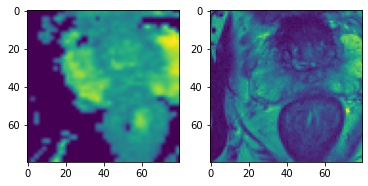

In [14]:
files_stored2 = []
files_stored2_adc = []
size = 80


for i in range(len(files_stored_ct)):
    x, y = ijk2[i][0], ijk2[i][1]
    pic = files_stored_ct[i][ijk2[i][2]-1][ijk2[i][1]-size:ijk2[i][1]+size, ijk2[i][0]-size:ijk2[i][0]+size]
    #print(pic.shape)
    pic = cv2.resize(pic,(80, 80))#80, 80
    #pic2 = files_stored[i][ijk[i][2]-1][ijk[i][1]-20:ijk[i][1]+20, ijk[i][0]-20:ijk[i][0]+20]
    files_stored2.append(pic)
#plt.imshow(files_stored2[0])
print(np.asarray(files_stored2[0]).shape)# dimensions ok with all the corrections. 

for i in range(len(files_stored)):
    x, y = ijk[i][0], ijk[i][1]
    pic = files_stored[i][ijk[i][2]-1][ijk[i][1]-20:ijk[i][1]+20, ijk[i][0]-20:ijk[i][0]+20]
    pic = cv2.resize(pic,(size, size))#80, 80
    #pic2 = files_stored[i][ijk[i][2]-1][ijk[i][1]-20:ijk[i][1]+20, ijk[i][0]-20:ijk[i][0]+20]
    files_stored2_adc.append(pic)
plt.figure()
plt.subplot(1,2,1)
plt.imshow(files_stored2_adc[0])
plt.subplot(1,2,2)
plt.imshow(files_stored2[0])
plt.show()


In [15]:
#ATTENTION: CNN not really DNN see real difference

batch_size = 32
img_height = size # 80
img_width = size # 80

#for now we are not going to test the training on the test database

In [16]:
final = np.zeros((len(files_stored_ct),img_height,img_height,2))

for n in range(len(files_stored2)):
    for i in range(len(files_stored2[0])):
        for j in range(len(files_stored2[0])):
            final[n][i][j][0] = files_stored2_adc[n][i][j]
            final[n][i][j][1] = files_stored2[n][i][j]
print(final.shape)

category = []
training_data = []
j=0
for i in range(len(clinsig)):
    if clinsig[i][3] == "TRUE":
        category.append(np.asarray([1,0]))
    else:
        category.append(np.asarray([0,1]))
        j +=1
print(len(category), j)#  we have a biais, keep in mind 

for k in range(len(category)):
    training_data.append([final[k], category[k]])
#print(test_data[0])

X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)

#print(X[0].reshape(-1, img_height, img_width, 1))
X = np.array(X).reshape(-1, img_height, img_width, 2)

y= np.asarray(y)

(324, 80, 80, 2)
324 250


In [17]:
#nmbre for splitting test patients from training patients
nbr = 254

seed = np.random.randint(0, 10000)
np.random.seed(seed)
np.random.shuffle(X)
np.random.seed(seed)
np.random.shuffle(y)

np.random.seed(seed)
np.random.shuffle(files_stored_ct)
np.random.seed(seed)
np.random.shuffle(files_stored)

np.random.seed(seed)
np.random.shuffle(clinsig)
np.random.seed(seed)
np.random.shuffle(clinsig2)

np.random.seed(seed)
np.random.shuffle(ijk)
np.random.seed(seed)
np.random.shuffle(ijk2)

In [18]:
X_test = X[nbr:]
X_test = X_test/255.0
y_test = y[nbr:]

nbr -=70
X_val = X[nbr:nbr+70]
y_val = y[nbr:nbr+70]

X_save = X[:nbr]
y_save = y[:nbr]

print(len(X_val), len(X_test), nbr)
print(y_val)

70 70 184
[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]]


In [19]:
#model.evaluate(X_test,y_test)

In [20]:
#model = Sequential()
#model = tf.keras.models.load_model('saved_model/model_combined')
#model.summary()

In [21]:
model_ADC = tf.keras.models.load_model('saved_model/ADC_model')
model_com = tf.keras.models.load_model('saved_model/model_combined')
model_COR = tf.keras.models.load_model('saved_model/COR_model')

In [22]:
#combined, t2, adc40
def combined_model(model1, model2, model3, input_im, label):
    
    adc=[i[:,:,0] for i in input_im]
    t2=[i[:,:,1] for i in input_im]
    
    adc_40 = [cv2.resize(u,(40,40)) for u in adc]

    t2 = np.array(t2).reshape(-1, 80, 80, 1)
    
    adc_40 = np.array(adc_40).reshape(-1, 40, 40, 1)
    
    first = model1.predict(input_im)
    second = model2.predict(t2)
    third = model3.predict(adc_40)
    
    result = []
    for i in range(len(first)):
        result.append(np.argmax(first[i]+second[i]+third[i]))

    acc = 0
    for i in range(len(label)):
        if result[i] != label[i,0]:
            acc+=1
    print(acc/len(label))

combined_model(model_com, model_COR, model_ADC, X_test, y_test)

0.8857142857142857


In [25]:
adc=[i[:,:,0] for i in X_test]
t2=[i[:,:,1] for i in X_test]

adc_40 = [cv2.resize(u,(40,40)) for u in adc]

t2 = np.array(t2).reshape(-1, 80, 80, 1)

adc_40 = np.array(adc_40).reshape(-1, 40, 40, 1)

model_com.evaluate(X_test,y_test)
model_COR.evaluate(t2, y_test)
model_ADC.evaluate(adc_40, y_test)

3/3 [==============================] - 0s 4ms/step - loss: 16985.6152 - accuracy: 0.7857


[16985.615234375, 0.7857142686843872]

In [26]:
0.8143*0.8571*0.7857+0.8143*(1-0.8571)*0.7857+(1-0.8143)*0.8571*0.7857+0.8143*0.8571*(1-0.7857)

0.914418046758

In [27]:
0.657*0.657*0.629+(1-0.657)*0.657*0.629*2+0.657*0.657*(1-0.629)

0.715140558